# Hydrogeodesy: Monitoring surface waters from space
### Exercise 2: Wide-Swath-Altimetry

Daniel Scherer, DGFI-TUM  
Wintersemester 2024/25

##### **Contents**
1. Introduction to the SWOT Pixel Cloud (PixC) product
2. Estimating lake water levels from SWOT PixC data
3. Bonus: Estimating river water levels and slope from SWOT


In this exercise, we will use the SWOT Pixel Cloud (PixC) product to estimate water levels.\
The SWOT PixC product is a Level 2 product, containing a point cloud of georeferenced water level estimates derived from interferometric radar measurements.\
This exercise builds on Exercise 1 and we will investigate the same target (Sam Rayburn Reservoir in Texas).

#### 2.1 Introduction to the SWOT Pixel Cloud (PixC) product

SWOT PixC data is provided by Cycles, Passes, and Tiles.\
Each tile covers an area of approximately 64 x 64 km, containing a point cloud with hundrets of MB of data.\
The Sam Rayburn Reservoir is covered by muiliple SWOT Pixel Cloud tiles of the ascending pass 578 and the ascending pass 259 as shown in Figure 1.\

<img src="Figures/SWOT.png" alt="Map" style="width: 200mm;"/>\
*Figure 1: Sam Rayburn Reservoir and the approximate footprints of the intersecting tiles of passes 259 and 578.*

To minimize data volume, we gathered the PixC data for the Sam Rayburn Reservoir in a single file from all tiles per pass and cycle.\
The gathered data contains only a subset of all the available variables in the PixC data:

**Geolocation**

| **Parameter**                | **Description**                                                                 |
|------------------------------|---------------------------------------------------------------------------------|
| **latitude**                  | Geographic latitude of each pixel's location.                                  |
| **longitude**                 | Geographic longitude of each pixel's location.                                 |
| **height**                    | The height above reference ellipsoid (m) |

**Corrections**
| **Parameter**                | **Description**                                                                 |
|------------------------------|---------------------------------------------------------------------------------|
| **instrument_phase_cor**      | Correction for phase errors caused by the radar instrument. **Already applied to height**                    |
| **instrument_range_cor**      | Correction for errors in range measurement due to instrument inaccuracies. **Already applied to height**     |
| **instrument_baseline_cor**   | Correction for baseline errors in radar measurements. **Already applied to height**                          |
| **iono_cor_gim_ka**           | Ionization correction based on the GIM model, specifically for Ka-band radar. **Already applied to height** |
| **model_dry_tropo_cor**       | Correction for dry tropospheric delay affecting radar signal propagation. **Already applied to height**      |
| **model_wet_tropo_cor**       | Correction for wet tropospheric delay due to moisture in the atmosphere. **Already applied to height**       |
| **height_cor_xover**          | Height correction from crossover adjustment (e.g., roll correction) (m) **Already applied to height** |
| **solid_earth_tide**          | Correction for solid Earth tides caused by gravitational forces from the moon and sun. |
| **pole_tide**                 | Correction for Earth's pole movement, affecting radar measurements.            |

**Quality Indicators and Classifications**
| **Parameter**                | **Description**                                                                 |
|------------------------------|---------------------------------------------------------------------------------|
| **sig0**                      | Radar bbackscatter coefficient (dB). Larger values represent more specular features while lower values represent rough surfaces. |
| **classification**            | Water classification of the point cloud **(1: land, 2: land_near_water, 3: water_near_land, 4: open_water, 5: dark_water, 6: low_coh_water_near_land, 7: open_low_coh_water)**               |
| **interferogram_qual**        | Quality flag assessing the reliability of the interferogram data.           |
| **geolocation_qual**          | Quality flag indicating the accuracy of the pixel’s geolocation data.          |
| **sig0_qual**                 | Quality flag for the radar backscatter coefficient, assessing data reliability. |
| **pixc_line_qual**            | Quality flag for the specific line in the pixel cloud, indicating its reliability. |
| **cross_track**            | Acrosstrack distance from the nadir point (m). |


The qualityflags should all be 0, indicating that the data is reliable. Values greater than 0 indicate that the data is suspect or bad.

For a detailed description you can refer to the [SWOT Level 2 HR PIXC Product Description](https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/web-misc/swot_mission_docs/pdd/D-56411_SWOT_Product_Description_L2_HR_PIXC_20231026_RevBcite.pdf).

**First, import the required libaries**

In [ ]:
import xarray as xr # for reading in netcdf files
import matplotlib.pyplot as plt # for plotting
import numpy as np # for array operations
import pandas as pd
from res import labels, classification_colors, norm, cmap, examples
from pathlib import Path

**Take a look at the following 4 examples:**

<img src="Figures/Example1.png" alt="Example1" style="width: 300mm;"/>
<img src="Figures/Example2.png" alt="Example2" style="width: 300mm;"/>
<img src="Figures/Example3.png" alt="Example3" style="width: 300mm;"/>
<img src="Figures/Example4.png" alt="Example4" style="width: 300mm;"/>



Note, that we already removed points with the classes "Land" and "Land near Water".

Although the 2D SWOT data is a hugh improvement compared to the classical nadir altimetry, it still contains some imperfect data, which must be removed before calculating the water surface elevation.

**Out of the four examples, identify the following states and discuss their reasons:**
- Insufficient surface roughness
- Good example
- Missing roll correction
- Exceeding the nominal observation limit

**Now load the dataset (ds) of Example 4:**

In [8]:
data_root = Path('data/SamRayburn/PixC/')
filename = next(data_root.glob(f'SWOT_L2_HR_PIXC_{examples[3]["cycle_nr"]}_{examples[3]["pass_nr"]}_*.nc'))
ds = xr.open_dataset(filename, engine='netcdf4')
ds

<xarray.Dataset>
Dimensions:                  (points: 566526)
Coordinates:
    latitude                 (points) float64 ...
    longitude                (points) float64 ...
Dimensions without coordinates: points
Data variables: (12/17)
    sig0                     (points) float32 ...
    classification           (points) float32 ...
    height                   (points) float32 ...
    height_cor_xover         (points) float32 ...
    model_dry_tropo_cor      (points) float32 ...
    model_wet_tropo_cor      (points) float32 ...
    ...                       ...
    instrument_baseline_cor  (points) float32 ...
    iono_cor_gim_ka          (points) float32 ...
    interferogram_qual       (points) float64 ...
    geolocation_qual         (points) float64 ...
    sig0_qual                (points) float64 ...
    cross_track              (points) float32 ...
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3275
    interferogram_size_range:    4662
    looks_to_efflooks:           1.5499389784911357
    num_azimuth_looks:           7.0
    azimuth_offset:              9

We access the values stored in the dataset as vectors similar to last exercise, e.g.:

```python
new_height = ds.height + 1 # Increase the value of all heights by 1
```

We can create a boolean vector by testing the data against a condition:
```python
ds.height > ds.height.mean() # Returns: array([False, False, False, ...,  True,  True,  True])
```

We can combined multiple conditions using the & (and) and | (or) operators:
```python
(ds.height > ds.height.mean()) & ((ds.classification == 4) | (ds.classification == 3)) # Returns: array([False, False, False, ...,  False,  False,  True])
```

**Now, based on the examples above, create a boolean mask vector that marks all outlier as False and all good data as True**\
- You will need the ds.classification, ds.height_cor_xover, and ds.cross_track values
- For the cross_track outliers you can either use the | parameter or use np.abs(ds.cross_track) to use absolute values

In [ ]:
quality_flags = (ds.interferogram_qual == 0) & (ds.geolocation_qual == 0) & (ds.sig0_qual == 0) # We already mask out data which are not valid according to the quality flags

mask = quality_flags & ... # Add your additional outlier criteria here
mask

In [45]:
minimum_abs_cross_track_distance = 10000 # in meters
classes = [4] # choose from 1,2,3,4,5,6,7
mask = np.isin(ds.classification, classes) & (np.abs(ds.cross_track) > minimum_abs_cross_track_distance) & (ds.height_cor_xover != 0) & (ds.interferogram_qual == 0) & (ds.geolocation_qual == 0) & (ds.sig0_qual == 0)
mask

<xarray.DataArray (points: 566526)>
array([False, False, False, ..., False, False, False])
Coordinates:
    latitude   (points) float64 31.06 31.06 31.06 31.06 ... 31.35 31.35 31.33
    longitude  (points) float64 -94.53 -94.53 -94.49 ... -94.08 -94.08 -93.98
Dimensions without coordinates: points

**Now we plot the data again with your outlier criteria**\
This can take some minutes

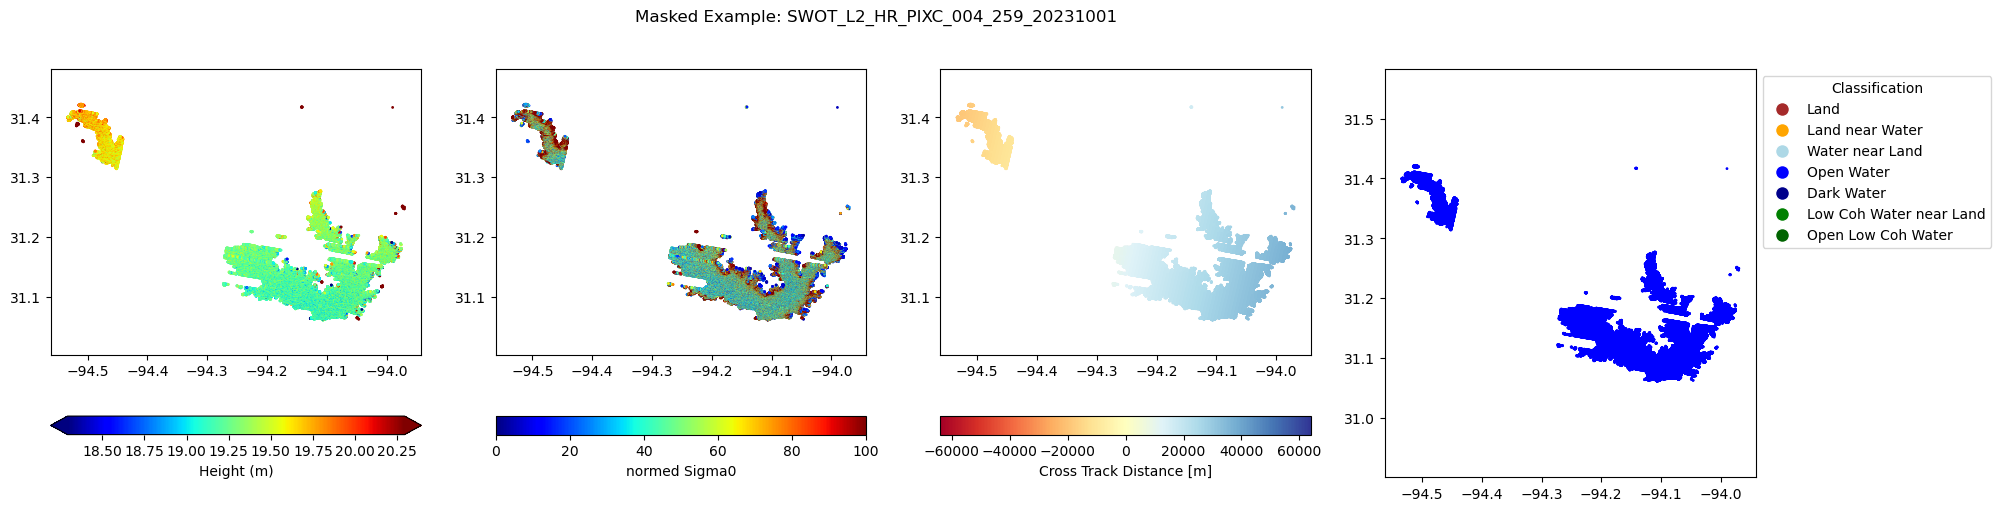

In [25]:
# Plot the data again with the outlier criteria applied

fig, axs = plt.subplots(1, 4, figsize=(22, 6))
plt.subplots_adjust(bottom=0.2)

plt.sca(axs[0])
mask = np.isin(ds.classification, classes) & (np.abs(ds.cross_track) > minimum_abs_cross_track_distance) & (ds.height_cor_xover != 0) & (ds.interferogram_qual == 0) & (ds.geolocation_qual == 0) & (ds.sig0_qual == 0)
plt.scatter(x=ds.longitude[mask], y=ds.latitude[mask], c=ds.height[mask], cmap='jet', s=1, vmin=ds.height.median().values - 1, vmax=ds.height.median().values + 1)
plt.colorbar(location='bottom', extend='both').set_label('Height (m)')
axs[0].axis('equal')

plt.sca(axs[1])
plt.scatter(x=ds.longitude[mask], y=ds.latitude[mask], c=ds.sig0[mask], cmap='jet', s=1, vmin=0, vmax=100)
plt.colorbar(location='bottom').set_label('normed Sigma0')
axs[1].axis('equal')

plt.sca(axs[2])
plt.scatter(x=ds.longitude[mask], y=ds.latitude[mask], c=ds.cross_track[mask], cmap='RdYlBu', s=1, vmin=-64000, vmax=64000)
plt.colorbar(location='bottom').set_label('Cross Track Distance [m]')
axs[2].axis('equal')

plt.sca(axs[3])
scatter = plt.scatter(
    x=ds.longitude[mask],
    y=ds.latitude[mask],
    c=ds.classification[mask],
    cmap=cmap,
    norm=norm,
    s=1
)

# Create a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
    for label, color in zip(labels.values(), classification_colors.values())
]
plt.legend(handles=handles, title="Classification", loc="upper left", bbox_to_anchor=(1, 1))
axs[3].axis('equal')
plt.suptitle(f'Masked Example: {filename.stem}')
plt.show()

Do you think that most of the outliers are removed?

#### 2.2 Estimating lake water levels from SWOT PixC data

**Plot a histogram of the valid heights:**

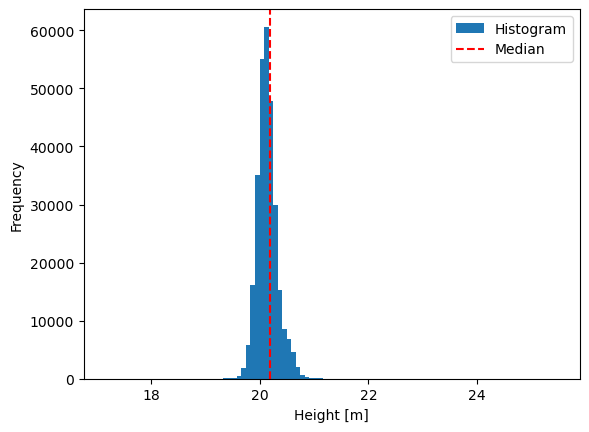

In [51]:
corrected_height = ds.height - ds.pole_tide - ds.solid_earth_tide

xr.plot.hist(corrected_height[mask & (corrected_height < corrected_height.quantile(0.9)) & (corrected_height > corrected_height.quantile(0.01))], bins=100, label='Histogram')
plt.gca().axvline(corrected_height.median().values, color='r', linestyle='--', label='Median')
plt.xlabel('Height [m]')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Take a look into the folder ```Figures/MoreExamples/``` for more examples of other cycles.

**What would be a better method than the median to obtain the average height?**

**What important quantity other than the average height can we extract from the data?**

**DAHITI uses a similar method to estimate the water height. Load and plot the time series below:**

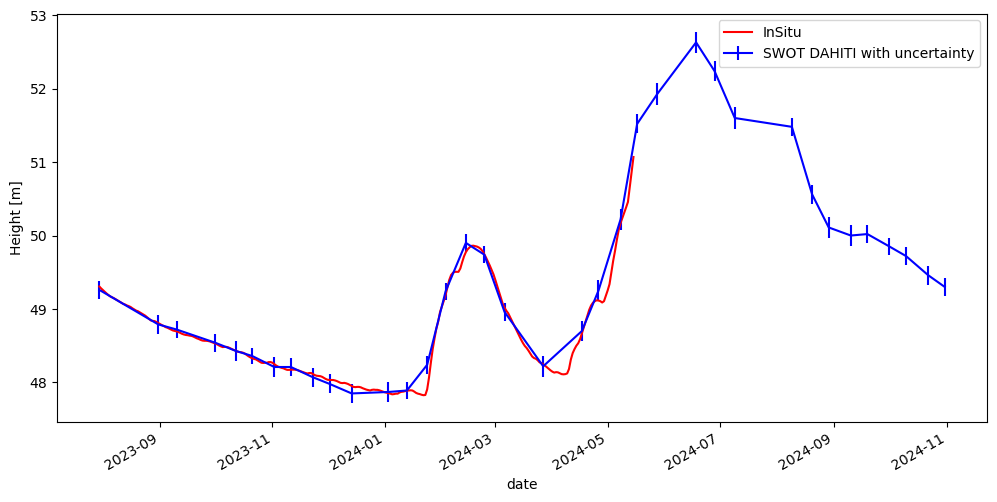

In [100]:
swot_dahiti_ts = pd.read_csv('data/SamRayburn/timeseries_swot.csv',delimiter=';', parse_dates=['date'], usecols=[0, 2]).set_index('date').height
dahiti_error_ts = pd.read_csv('data/SamRayburn/timeseries_swot.csv',delimiter=';', parse_dates=['date'], usecols=[0, 3]).set_index('date').error
insitu_ts = pd.read_csv('data/SamRayburn/insitu_wse.csv',delimiter=' ', names=['date', 'height'], parse_dates=['date'], usecols=[0, 1]).set_index('date').height

bias = (swot_dahiti_ts - insitu_ts).median()
swot_dahiti_ts = swot_dahiti_ts - bias

fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(swot_dahiti_ts.index, swot_dahiti_ts, yerr=dahiti_error_ts, fmt='', label='SWOT DAHITI with uncertainty', color='b')
insitu_ts[insitu_ts.index >= swot_dahiti_ts.index.min()].plot(ax=ax, label='InSitu', color='r')


plt.legend()
plt.ylabel('Height [m]')
plt.show()

Additionally, calculate the RMSE of the SWOT data:

In [105]:
def calc_rmse(predictions, truth):
    rmse = np.sqrt(((predictions - truth) ** 2).mean())
    return rmse

rmse = calc_rmse(swot_dahiti_ts, insitu_ts)
print(f'RMSE: {rmse.round(3)} m')

RMSE: 0.092 m


**How would you describe the results compared to the nadir altimetry in the last excercise?**

**What are the major benefits of the wide swath SWOT mission?**

#### 2.3 Bonus: Estimating river water levels and slope from SWOT

**Load the SWOT data for a reach of the Oder River**

We already isolated the river from the remaining pointcloud and the data contains only points of the class "Open Water"

In [157]:
filename = 'data/Oder/SWOT_L2_HR_PIXC_020_557_20240909.nc'
ds = xr.open_dataset(filename, engine='netcdf4')
ds

<xarray.Dataset>
Dimensions:                  (points: 1593)
Coordinates:
    latitude                 (points) float64 ...
    longitude                (points) float64 ...
Dimensions without coordinates: points
Data variables: (12/17)
    sig0                     (points) float32 ...
    classification           (points) float32 ...
    height                   (points) float32 ...
    height_cor_xover         (points) float32 ...
    model_dry_tropo_cor      (points) float32 ...
    model_wet_tropo_cor      (points) float32 ...
    ...                       ...
    instrument_baseline_cor  (points) float32 ...
    iono_cor_gim_ka          (points) float32 ...
    interferogram_qual       (points) float64 ...
    geolocation_qual         (points) float64 ...
    sig0_qual                (points) float64 ...
    cross_track              (points) float32 ...
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3265
    interferogram_size_range:    4758
    looks_to_efflooks:           1.5440293172364024
    num_azimuth_looks:           7.0
    azimuth_offset:              8

Plot the data:

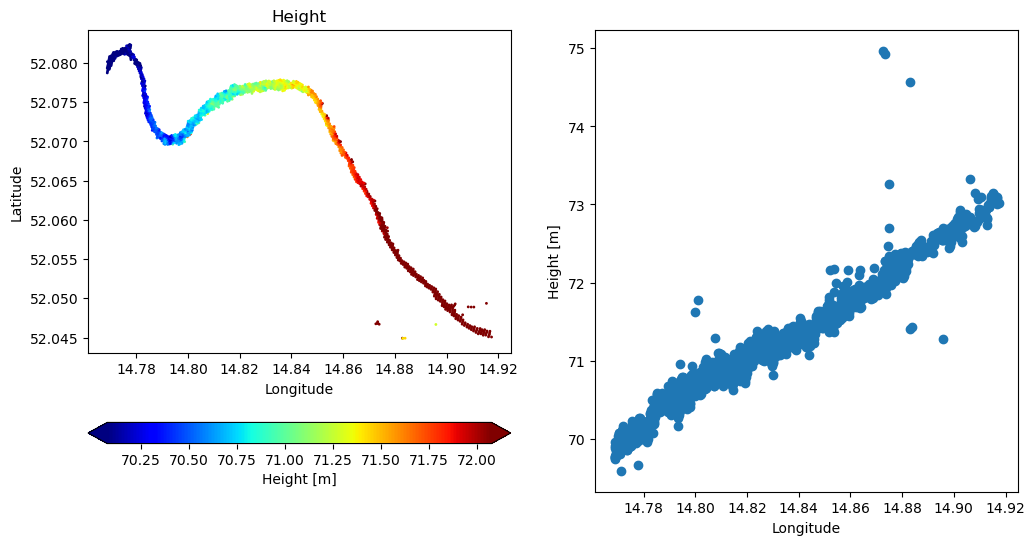

In [158]:
fig, axs = plt.subplots(1,2,figsize=(12, 6))

plt.sca(axs[0])
plt.scatter(ds.longitude, ds.latitude, c=ds.height, cmap='jet', s=1, vmin=ds.height.median().values - 1, vmax=ds.height.median().values + 1)
plt.colorbar(location='bottom', extend='both').set_label('Height [m]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Height')

plt.sca(axs[1]) 
plt.scatter(ds.longitude, ds.height)
plt.xlabel('Longitude')
plt.ylabel('Height [m]')
plt.show()

**Think about a method to estimate a representive water level of the river reach that works with different .**

**Estimate the slope of the reach [m/km]**\
For this task you would need the distance along the river.\
As a proxy, we can convert the longitude to meters:
```python
longitude_km = ds.longitude * np.cos(np.radians(52)) * 111.32 # At the equator, 1 degree longitude equals 111.32 km. We have to transform the value for 52 degree latitude.
```

You might need the [np.polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) function.

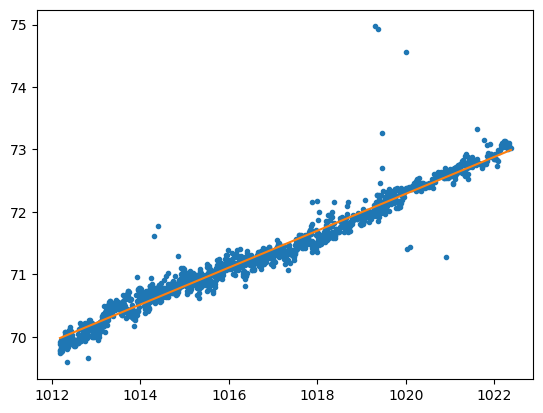

Slope [mm/km]: 229.147


In [173]:
longitude_km = ds.longitude * np.cos(np.radians(52)) * 111.32
xp = np.linspace(longitude_km.min(), longitude_km.max(), 100)
coef = np.polyfit(longitude_km, ds.height, 1)
poly1d_fn = np.poly1d(coef)
_ = plt.plot(longitude_km, ds.height, '.', xp, poly1d_fn(xp), '-')
plt.show()
print("Slope [mm/km]:", np.abs(coef[1]).round(3))